In [ ]:
#accessing google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#reading the dataset
import pandas as pd
import pickle 
import numpy as np
from tqdm import tqdm_notebook as tqdm
from IPython.core.interactiveshell import InteractiveShell

np.random.seed(2)
strategy_type = 'original'
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/IBM_cleaned.csv")
df['labels'] = df['labels'].astype(np.int8)
display(df)

,Unnamed: 0,Date,Open,High,Low,Close(t),Volume,SD20,Upper_Band,Lower_Band,...,QQQ_MA20,QQQ_MA50,SnP_Close,SnP(t-1)),SnP(t-5),DJIA_Close,DJIA(t-1)),DJIA(t-5),Close_forcast,labels
0,0,20-10-00,60.61,61.32,60.01,60.37,9369200,5.099733,81.164966,60.766034,...,73.1995,79.0922,1396.93,1388.76,1374.17,10226.59,10142.98,10192.18,59.17,2
1,1,23-10-00,60.37,60.53,58.02,59.17,9338600,5.429033,80.863565,59.147435,...,73.0130,79.0072,1395.78,1396.93,1374.62,10271.72,10226.59,10238.80,58.26,2
2,2,24-10-00,59.25,60.13,57.46,58.26,8826200,5.838469,80.800438,57.446562,...,72.7110,78.8242,1398.13,1395.78,1349.97,10393.07,10271.72,10089.71,55.79,2
3,3,25-10-00,57.66,57.94,55.39,55.79,14058500,6.365900,80.885801,55.422199,...,72.2015,78.5604,1364.90,1398.13,1342.13,10326.48,10393.07,9975.02,59.09,1
4,4,26-10-00,56.07,59.17,55.83,59.09,10135700,6.545417,80.527834,54.346166,...,71.6920,78.3152,1364.44,1364.90,1388.76,10380.12,10326.48,10142.98,59.69,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4974,4974,31-07-20,121.12,121.40,119.53,121.35,5277700,3.670160,128.627819,113.947181,...,260.6195,247.9884,3271.12,3246.22,3215.63,26428.32,26313.65,26469.89,122.70,2
4975,4975,03-08-20,121.90,122.80,120.57,122.70,3526100,3.628057,128.746613,114.234387,...,261.1690,248.8066,3294.61,3271.12,3239.41,26664.40,26428.32,26584.77,124.21,2
4976,4976,04-08-20,122.22,124.23,122.22,124.21,3466100,3.438768,128.775535,115.020465,...,261.8575,249.6290,3306.51,3294.61,3218.44,26828.47,26664.40,26379.28,123.83,2
4977,4977,05-08-20,125.09,125.11,123.00,123.83,3675400,3.186404,128.652807,115.907193,...,262.4105,250.4772,3327.77,3306.51,3258.44,27201.52,26828.47,26539.57,124.49,2


In [ ]:
#splitting and normalising data into training/validation/testing sets
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

list_features = list(df.loc[:, 'Open':'Close_forcast'].columns)
print('Total number of features', len(list_features))
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'Open':'Close_forcast'].values, df['labels'].values, train_size=0.8, 
                                                    test_size=0.2, random_state=2, shuffle=True, stratify=df['labels'].values)
if 0.7*x_train.shape[0] < 2500:
    train_split = 0.8
else:
    train_split = 0.7
# train_split = 0.7
print('train_split =',train_split)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split, 
                                                random_state=2, shuffle=True, stratify=y_train)
mm_scaler = MinMaxScaler(feature_range=(0, 1))
x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

x_main = x_train.copy()
print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))

Total number of features 62
train_split = 0.7
Shape of x, y train/cv/test (2788, 62) (2788,) (1195, 62) (1195,) (996, 62) (996,)


In [ ]:
num_features = 49
selection_method = 'all'
topk = 57 if selection_method == 'all' else num_features

In [ ]:
#selecting 49 best features out of total 62
%%time
from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

if selection_method == 'anova' or selection_method == 'all':
    select_k_best = SelectKBest(f_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_main, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_main, y_train)
    
    selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(selected_features_anova)
    print(select_k_best.get_support(indices=True))
    print("****************************************")
    
if selection_method == 'mutual_info' or selection_method == 'all':
    select_k_best = SelectKBest(mutual_info_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_main, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_main, y_train)

    selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(len(selected_features_mic), selected_features_mic)
    print(select_k_best.get_support(indices=True))

('Open', 'High', 'Low', 'Close(t)', 'Volume', 'SD20', 'Upper_Band', 'Lower_Band', 'S_Close(t-1)', 'S_Close(t-2)', 'S_Close(t-3)', 'S_Close(t-5)', 'S_Open(t-1)', 'MA5', 'MA10', 'MA20', 'MA50', 'MA200', 'EMA10', 'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'MACD_EMA', 'ATR', 'ADX', 'ROC', 'RSI', 'William%R', 'SO%K', 'STD5', 'ForceIndex1', 'ForceIndex20', 'Day', 'DayofWeek', 'DayofYear', 'Week', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_leap_year', 'Month', 'QQQ_Close', 'QQQ(t-1)', 'QQQ(t-2)', 'QQQ(t-5)', 'QQQ_MA10', 'QQQ_MA20', 'QQQ_MA50', 'SnP_Close', 'SnP(t-1))', 'DJIA_Close', 'DJIA(t-1))', 'Close_forcast')
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 47 48 49 50
 51 52 53 54 55 56 58 59 61]
****************************************


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [27 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


57 ('Low', 'Volume', 'SD20', 'S_Close(t-1)', 'S_Close(t-2)', 'S_Close(t-3)', 'S_Close(t-5)', 'S_Open(t-1)', 'MA5', 'MA10', 'MA20', 'MA50', 'MA200', 'EMA10', 'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'MACD_EMA', 'ATR', 'ADX', 'CCI', 'ROC', 'RSI', 'William%R', 'SO%K', 'STD5', 'ForceIndex1', 'ForceIndex20', 'Day', 'DayofWeek', 'DayofYear', 'Week', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Is_leap_year', 'Year', 'Month', 'QQQ_Close', 'QQQ(t-1)', 'QQQ(t-2)', 'QQQ(t-5)', 'QQQ_MA10', 'QQQ_MA20', 'QQQ_MA50', 'SnP_Close', 'SnP(t-1))', 'SnP(t-5)', 'DJIA_Close', 'DJIA(t-1))', 'DJIA(t-5)', 'Close_forcast')
[ 2  4  5  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61]
CPU times: user 1.3 s, sys: 913 µs, total: 1.3 s
Wall time: 1.33 s


In [ ]:
#continued
if selection_method == 'all':
    common = list(set(selected_features_anova).intersection(selected_features_mic))
    print("common selected featues", len(common), common)
    if len(common) < num_features:
        raise Exception('number of common features found {} < {} required features. Increase "topk variable"'.format(len(common), num_features))
    feat_idx = []
    for c in common:
        feat_idx.append(list_features.index(c))
    feat_idx = sorted(feat_idx[0:49])
    print(feat_idx)

common selected featues 52 ['Is_year_end', 'SnP_Close', 'SD20', 'S_Close(t-5)', 'ForceIndex1', 'DJIA_Close', 'S_Close(t-2)', 'EMA10', 'Is_month_end', 'S_Close(t-3)', 'S_Close(t-1)', 'MA50', 'DayofYear', 'EMA50', 'DayofWeek', 'QQQ_MA10', 'Is_leap_year', 'ROC', 'DJIA(t-1))', 'ADX', 'MACD', 'QQQ_MA20', 'SO%K', 'S_Open(t-1)', 'SnP(t-1))', 'QQQ_Close', 'MACD_EMA', 'Week', 'Day', 'QQQ(t-1)', 'Close_forcast', 'MA10', 'Month', 'MA5', 'ForceIndex20', 'QQQ(t-2)', 'QQQ_MA50', 'Is_quarter_start', 'Is_month_start', 'EMA100', 'Is_quarter_end', 'EMA20', 'William%R', 'MA20', 'QQQ(t-5)', 'EMA200', 'Volume', 'ATR', 'RSI', 'Low', 'MA200', 'STD5']
[4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 61]


In [ ]:
#display shape of dataframes
if selection_method == 'all':
    x_train = x_train[:, feat_idx]
    x_cv = x_cv[:, feat_idx]
    x_test = x_test[:, feat_idx]

print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, 
                                                             y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))

Shape of x, y train/cv/test (2788, 49) (2788,) (1195, 49) (1195,) (996, 49) (996,)


In [ ]:
#displaying spread of buy/sell
_labels, _counts = np.unique(y_train, return_counts=True)
print("percentage of class 0 = {}, class 1 = {}".format(_counts[0]/len(y_train) * 100, _counts[1]/len(y_train) * 100))

percentage of class 0 = 6.276901004304161, class 1 = 6.1334289813486365


In [ ]:
#initializing necessary functions
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from keras import backend as K
from keras.utils import get_custom_objects
import numpy as np

def get_sample_weights(y):

    y = y.astype(int)  
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    
    print("real class weights are {}".format(class_weights), np.unique(y))
    print("value_counts", np.unique(y, return_counts=True))
    sample_weights = y.copy().astype(float)
    for i in np.unique(y):
        sample_weights[sample_weights == i] = class_weights[i] 
        
    return sample_weights

def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

def f1_weighted(y_true, y_pred):
    y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)  
    rows, cols = conf_mat.get_shape()
    size = y_true_class.get_shape()[0]
    precision = tf.constant([0, 0, 0]) 
    recall = tf.constant([0, 0, 0])
    class_counts = tf.constant([0, 0, 0])

    def get_precision(i, conf_mat):
        print("prec check", conf_mat, conf_mat[i, i], tf.reduce_sum(conf_mat[:, i]))
        precision[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[:, i]))
        recall[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[i, :]))
        tf.add(i, 1)
        return i, conf_mat, precision, recall

    def tf_count(i):
        elements_equal_to_value = tf.equal(y_true_class, i)
        as_ints = tf.cast(elements_equal_to_value, tf.int32)
        count = tf.reduce_sum(as_ints)
        class_counts[i].assign(count)
        tf.add(i, 1)
        return count

    def condition(i, conf_mat):
        return tf.less(i, 3)

    i = tf.constant(3)
    i, conf_mat = tf.while_loop(condition, get_precision, [i, conf_mat])

    i = tf.constant(3)
    c = lambda i: tf.less(i, 3)
    b = tf_count(i)
    tf.while_loop(c, b, [i])

    weights = tf.math.divide(class_counts, size)
    numerators = tf.math.multiply(tf.math.multiply(precision, recall), tf.constant(2))
    denominators = tf.math.add(precision, recall)
    f1s = tf.math.divide(numerators, denominators)
    weighted_f1 = tf.reduce_sum(tf.math.multiply(f1s, weights))
    return weighted_f1

def f1_metric(y_true, y_pred):
    """
    this calculates precision & recall 
    """

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

get_custom_objects().update({"f1_metric": f1_metric, "f1_weighted": f1_weighted})

In [ ]:
#applying weights to output dataframe
sample_weights = get_sample_weights(y_train)
print("Test sample_weights")
rand_idx = np.random.randint(0, 1000, 30)
print(y_train[rand_idx])
print(sample_weights[rand_idx])

real class weights are [5.31047619 5.43469786 0.38056238] [0 1 2]
value_counts (array([0, 1, 2]), array([ 175,  171, 2442]))
Test sample_weights
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2]
[0.38056238 0.38056238 0.38056238 0.38056238 0.38056238 0.38056238
 0.38056238 0.38056238 0.38056238 0.38056238 0.38056238 0.38056238
 0.38056238 0.38056238 0.38056238 0.38056238 0.38056238 0.38056238
 0.38056238 5.43469786 0.38056238 0.38056238 0.38056238 0.38056238
 0.38056238 0.38056238 0.38056238 0.38056238 0.38056238 0.38056238]


In [ ]:
#one-hot encoding the output dataframes
one_hot_enc = OneHotEncoder(sparse_output=False, categories='auto') 
y_train = one_hot_enc.fit_transform(y_train.reshape(-1, 1))
print("y_train",y_train.shape)
y_cv = one_hot_enc.transform(y_cv.reshape(-1, 1))
y_test = one_hot_enc.transform(y_test.reshape(-1, 1))

y_train (2788, 3)


In [ ]:
#converting dataframes to images
dim = int(np.sqrt(num_features))
x_train = reshape_as_image(x_train, dim, dim)
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)
print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

final shape of x, y train/test (2788, 7, 7, 3) (2788, 3) (996, 7, 7, 3) (996, 3)


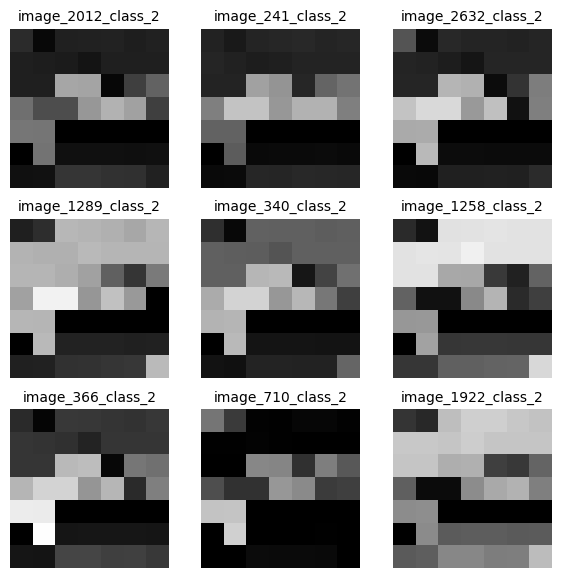

In [ ]:
#plotting images
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7, 7))
columns = rows = 3
for i in range(1, columns*rows +1):
    index = np.random.randint(len(x_train))
    img = x_train[index]
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('image_'+str(index)+'_class_'+str(np.argmax(y_train[index])), fontsize=10)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.imshow(img)
plt.show()

In [ ]:
#creating keras model & initializing GA parameters
import keras
import pygad.kerasga
import numpy
import pygad

def fitness_func(ga_instance, solution, sol_idx):
    global data_inputs, data_outputs, keras_ga, model
    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model,weights_vector=solution)
    model.set_weights(weights=model_weights_matrix)
    predictions = model.predict(data_inputs)
    cce = keras.losses.CategoricalCrossentropy()
    solution_fitness = 1.0 / (cce(data_outputs, predictions).numpy() + 0.00000001)
    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
  
input_layer = keras.layers.Input(shape=(7, 7, 3))
conv_layer1 = keras.layers.Conv2D(filters=10,kernel_size=2,activation="relu")(input_layer)
conv_layer2 = keras.layers.Conv2D(filters=10,kernel_size=2,activation="relu")(conv_layer1)
flatten_layer  = keras.layers.Flatten()(conv_layer2)
dense_layer = keras.layers.Dense(25, activation="relu")(flatten_layer)
output_layer = keras.layers.Dense(3, activation="softmax")(dense_layer)
model = keras.Model(inputs=input_layer, outputs=output_layer)

keras_ga = pygad.kerasga.KerasGA(model=model,num_solutions=10)

data_inputs = x_train
data_outputs = y_train
num_generations = 200
num_parents_mating = 3
initial_population = keras_ga.population_weights

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation, mutation_type="random")

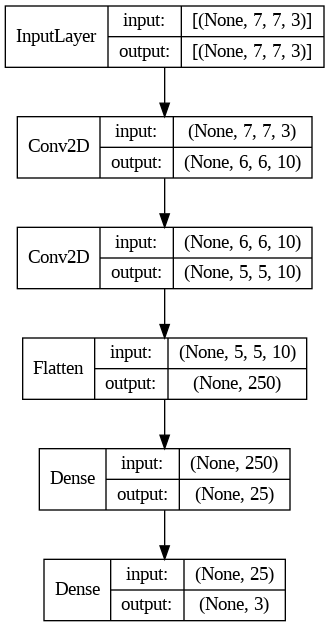

In [ ]:
#displaying keras model
from IPython.display import SVG
from keras.utils import model_to_dot, plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [ ]:
#running iterations
ga_instance.run()

88/88 [==============================] - 0s 2ms/step
Generation = 1
88/88 [==============================] - 0s 2ms/step
Fitness    = 0.9391153991809075
88/88 [==============================] - 0s 2ms/step
Generation = 2
88/88 [==============================] - 0s 3ms/step
Fitness    = 1.906940378112931
88/88 [==============================] - 0s 2ms/step
Generation = 3
88/88 [==============================] - 0s 2ms/step
Fitness    = 1.9727948617238673
88/88 [==============================] - 0s 2ms/step
Generation = 4
88/88 [==============================] - 0s 3ms/step
Fitness    = 2.0492737497708435
88/88 [==============================] - 0s 2ms/step
Generation = 5
88/88 [==============================] - 0s 2ms/step
Fitness    = 2.0492737497708435
88/88 [==============================] - 0s 2ms/step
Generation = 6
88/88 [==============================] - 0s 3ms/step
Fitness    = 2.0492737497708435
88/88 [==============================] - 0s 2ms/step
Generation = 7
88/88 [========

In [ ]:
#saving model
ga_instance.save(filename='CNN_GA')

/usr/local/lib/python3.9/dist-packages/pygad/visualize/plot.py:21: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


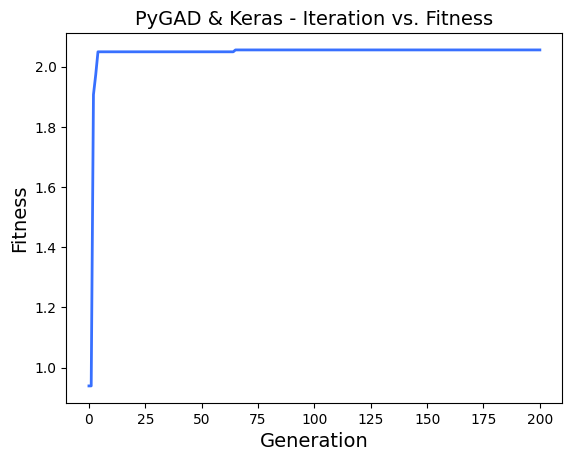

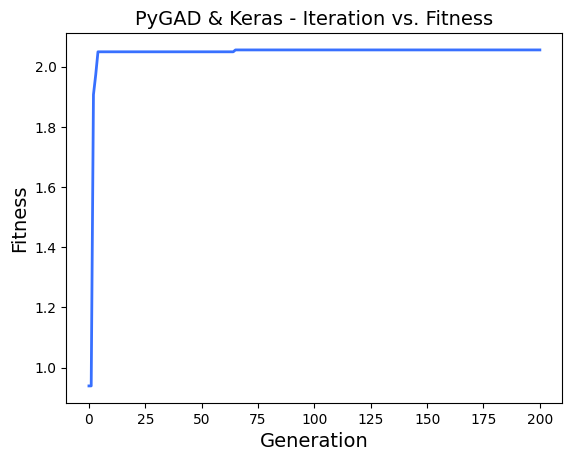

In [ ]:
#plotting model
ga_instance.plot_result(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=2)

In [ ]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

88/88 [==============================] - 0s 3ms/step
Fitness value of the best solution = 2.05553495386175


In [ ]:
# Fetch the parameters of the best solution.
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,weights_vector=solution)
model.set_weights(best_solution_weights)
predictions = model.predict(x_test)
print("Predictions : \n", predictions)

32/32 [==============================] - 0s 2ms/step
Predictions : 
 [[0.15861899 0.03200809 0.80937284]
 [0.0780949  0.03088697 0.8910182 ]
 [0.13381983 0.03815467 0.82802546]
 ...
 [0.15444113 0.05804578 0.7875131 ]
 [0.15403378 0.09817137 0.74779487]
 [0.0244591  0.01591459 0.9596263 ]]


In [ ]:
# Calculate the categorical crossentropy for the trained model.
cce = keras.losses.CategoricalCrossentropy()
print("Categorical Crossentropy : ", cce(y_test, predictions).numpy())

Categorical Crossentropy :  0.5310441


In [ ]:
# Calculate the classification accuracy for the trained model.
ca = keras.metrics.CategoricalAccuracy()
ca.update_state(y_test, predictions)
ca = ca.result().numpy()
print("Accuracy: ", ca)

Accuracy:  0.875502


In [ ]:
# Calculate the f1 score for the trained model.
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, cohen_kappa_score
pred_classes = np.argmax(predictions, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test_classes, pred_classes)

f1_weighted = f1_score(y_test_classes, pred_classes, labels=None, 
         average='weighted', sample_weight=None)
print("F1 score (weighted)", f1_weighted)
print("F1 score (macro)", f1_score(y_test_classes, pred_classes, labels=None, 
         average='macro', sample_weight=None))
print("F1 score (micro)", f1_score(y_test_classes, pred_classes, labels=None, 
         average='micro', sample_weight=None))

F1 score (weighted) 0.8173851723811736
F1 score (macro) 0.3112062812276945
F1 score (micro) 0.8755020080321284
